In [2]:
from system import *
from math import floor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as color
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pylab as pl

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

e_field = zero_field()
b_field = t89(7)
system  = System(e_field, b_field)

Load IGRF coefficients ...


In [23]:
system.load("EQ_5000_10_1e6_1-90_0-360")

Loaded files containing 916.10 megabytes of information.


In [26]:
from system import *
from math import floor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as color
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pylab as pl

e_field = zero_field()
b_field = t89(7)
system  = System(e_field, b_field)

system.populate(2000,
                delta(rr[45, :]),
                delta(1e6),
                uniform(np.radians(0), np.radians(90)),
                uniform(np.radians(0), np.radians(360))
               )

system.solve(15, 1e-4, 1e-3)

100%|██████████| 2000/2000 [00:00<00:00, 4796.86it/s]


In [27]:
system.solve(15, 1e-4, 1e-3)

100%|██████████| 2000/2000 [17:40<00:00,  1.89it/s]


In [28]:
system.save("pres3")

Saved files containing 2.68 gigabytes of information.


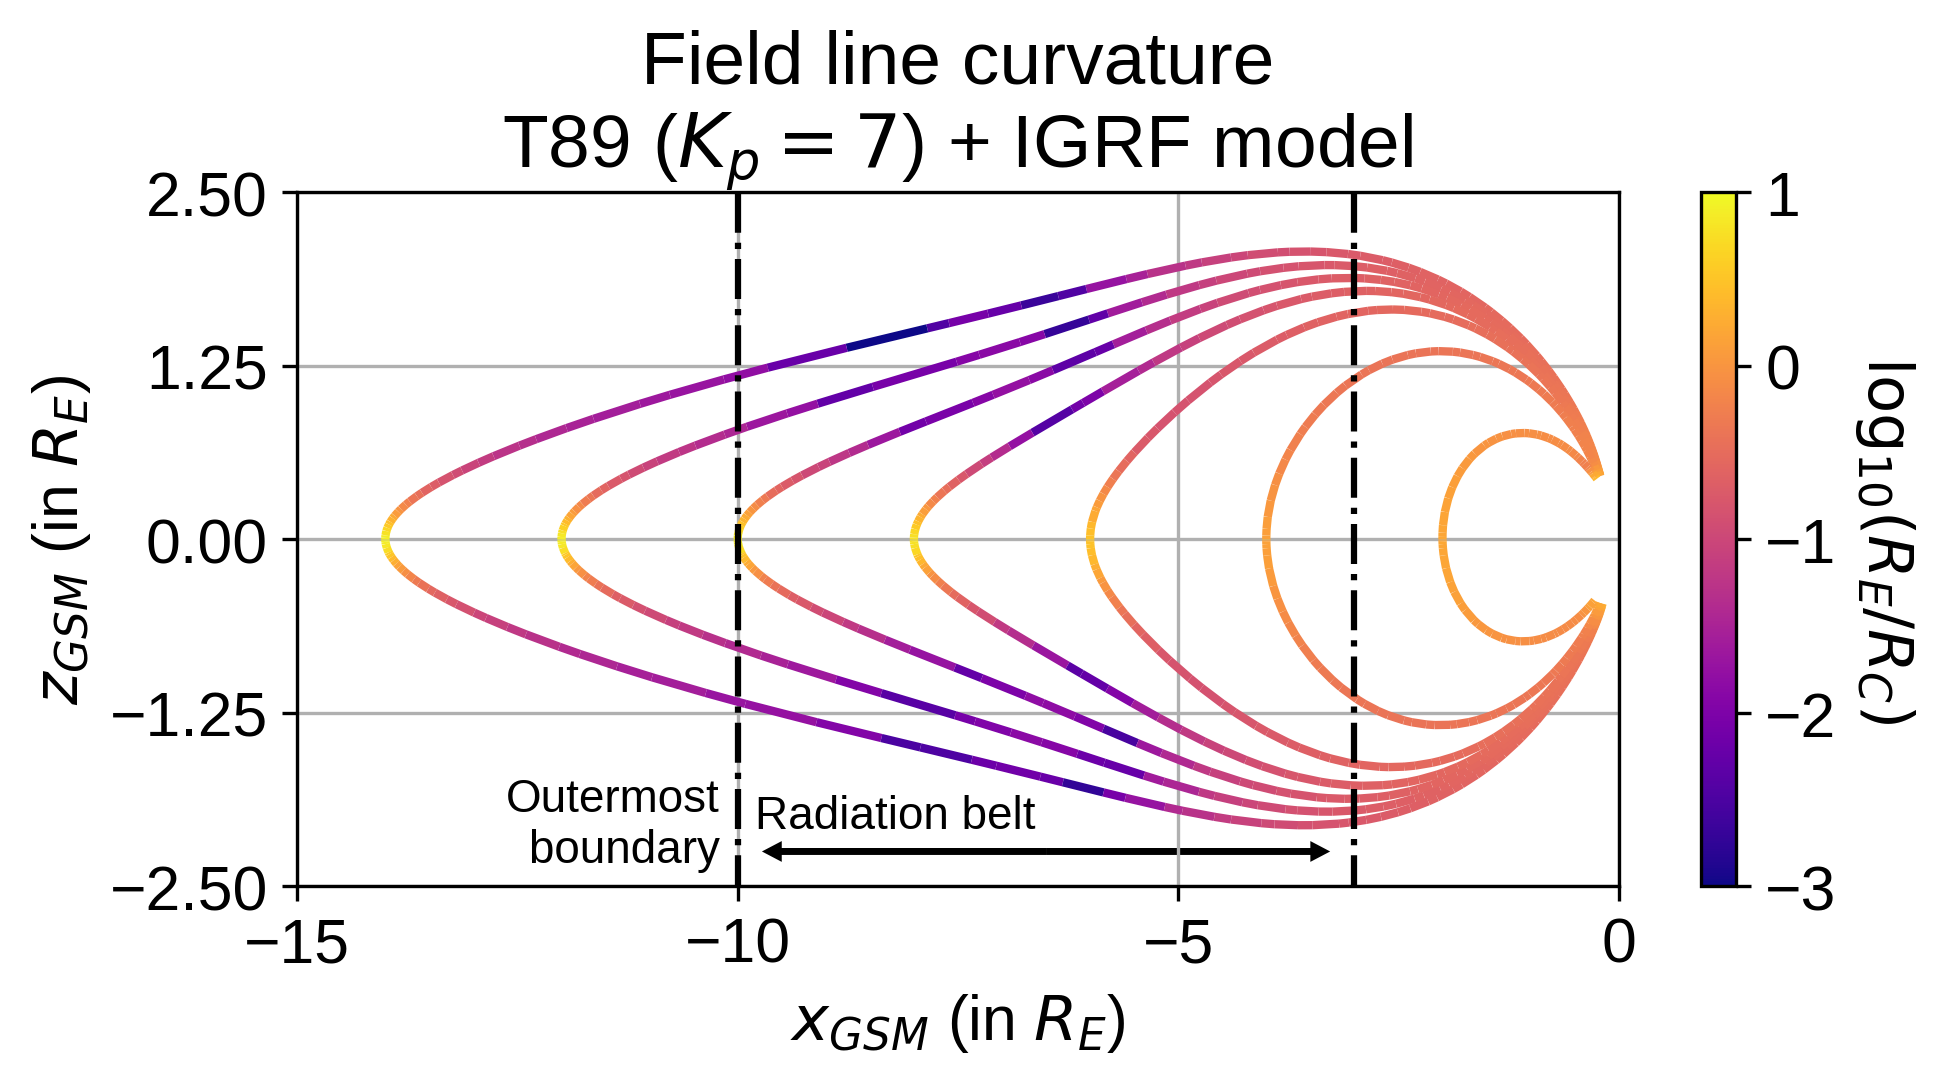

In [70]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'
    
n = 7
fig = plt.figure(figsize=(6, 3))

for i, x in enumerate(np.linspace(-14 * Re, -2 * Re, n)):
    rr = field_line(b_field, np.array([x, 0, 0]), 1e-1)
    cu = np.zeros(len(rr[:, 0]))

    for i, r in enumerate(rr):
        R_c = flc(b_field, r)
        cu[i] = np.log10(1.0 / (R_c / Re))

    points = np.array([rr[:, 0] / Re, rr[:, 2] / Re]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = plt.Normalize(-3, 1)
    lc = LineCollection(segments, cmap='plasma', norm=norm)
    lc.set_array(cu)
    lc.set_linewidth(2)
    line = plt.gca().add_collection(lc)


plt.xlabel(r'$x_{GSM}$ (in $R_E$)')
plt.xlim([-15, 0])
plt.xticks(np.linspace(-15, 0, 4))

plt.ylabel(r'$z_{GSM}$ (in $R_E$)')
plt.ylim(-2.5, 2.5)
plt.yticks(np.linspace(2.5, -2.5, 5))

cbar = fig.colorbar(line, ax=plt.gca())
cbar.ax.set_ylabel(r'$\log_{10}(R_E/R_C)$', rotation=-90, va="bottom")

plt.vlines([-10, -3], -4, 4, linestyle='-.')
plt.arrow(-6.5, -2.25, 3, 0, shape='full', width=0.05, linewidth=0, color='black')
plt.arrow(-6.5, -2.25, -3, 0, shape='full', width=0.05, linewidth=0, color='black')
plt.text(-10.2, -2.4, "Outermost\nboundary", va='bottom', ha='right', fontsize=11)
plt.text(-9.8, -2.15, "Radiation belt", va='bottom', ha='left', fontsize=11)

plt.title('Field line curvature\nT89 ($K_p=7$) + IGRF model')

plt.grid()
plt.tight_layout(pad=-1.0)
plt.show()

In [30]:
rr = field_line(b_field, np.array([-10 * Re, 0, 0]), 1e-6)

In [37]:
b_vec, b_mag, b_rad_mag = b_along_path(b_field, rr)

In [38]:
def b_mp(deg):
    return np.abs(b_mag - np.amin(b_mag) / np.sin(np.radians(deg))**2).argmin()

In [68]:
b_vec, b_mag, b_rad_mag = b_along_path(b_field, rr)

In [42]:
b_mag.argmin()

AttributeError: 'CPUDispatcher' object has no attribute 'argmin'

In [130]:
deg = 1.9
b_ratio = np.sqrt(b_mag[b_mp(deg)] / np.amin(b_mag))
new_sin = b_ratio * np.sin(np.radians(deg))

if new_sin > 1:
    if b_mp(deg) > b_mag.argmin():
        b_ratio = np.sqrt(b_mag[b_mp(deg) - 1] / np.amin(b_mag))
    else:
        b_ratio = np.sqrt(b_mag[b_mp(deg) + 1] / np.amin(b_mag))
        
new_sin = b_ratio * np.sin(np.radians(deg))      

if new_sin <= 1:
    print(np.degrees(np.arcsin(new_sin)))

89.21051627843985


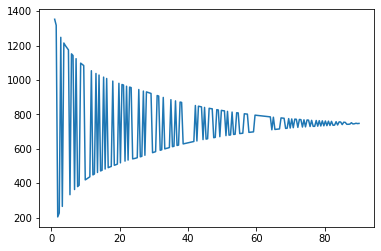

In [69]:
plt.plot(np.linspace(1, 90, 200), [b_mp(d) for d in np.linspace(1, 90, 200)])

In [73]:
b_mag

array([0.00124818, 0.0012164 , 0.00115703, ..., 0.00091884, 0.00093278,
       0.00095869])

In [70]:
len(np.unique([b_mp(d) for d in np.linspace(1, 90, 200)]))

198

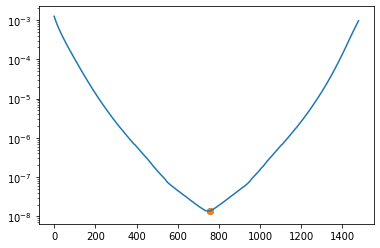

In [71]:
plt.semilogy(b_mag)
deg = 85
plt.scatter(b_mp(deg), b_mag[b_mp(deg)])
plt.scatter(b_mp(deg), np.amin(b_mag) / np.sin(np.radians(deg))**2)
plt.show()

In [18]:
deg = 20

system.populate_by_eq_pa(4,
                         delta(10),
                         delta(1e6),
                         delta(np.radians(deg)),
                         uniform(0, 2 * np.pi)
                        )

100%|██████████| 4/4 [00:00<00:00, 1747.63it/s]


In [19]:
system.solve(1, 1e-6, 1e-4)

100%|██████████| 4/4 [00:22<00:00,  5.55s/it]


In [20]:
@njit
def eq_pa_from_mu(history, intrinsic, b_min):
    num_particles = len(history[:, 0, 0, 0])
    steps = len(history[0, :, 0, 0])

    bm  = b_mag(history)
    pa  = np.radians(pitch_angle(history))
    
    history_new = np.zeros((num_particles, steps))

    for i in range(num_particles):
        for j in range(steps):
            history_new[i, j] = np.arcsin(np.sqrt(b_min / bm[i, j]) * np.sin(pa[i, j]))
            
    return np.degrees(history_new)

In [21]:
rr = field_line(b_field, np.array([-10 * Re, 0, 0]), 1e-6)
bv, bm, brm = b_along_path(b_field, rr)
mu = eq_pa_from_mu(system.history, system.ics[:, 4, 0:2], np.amin(bm))

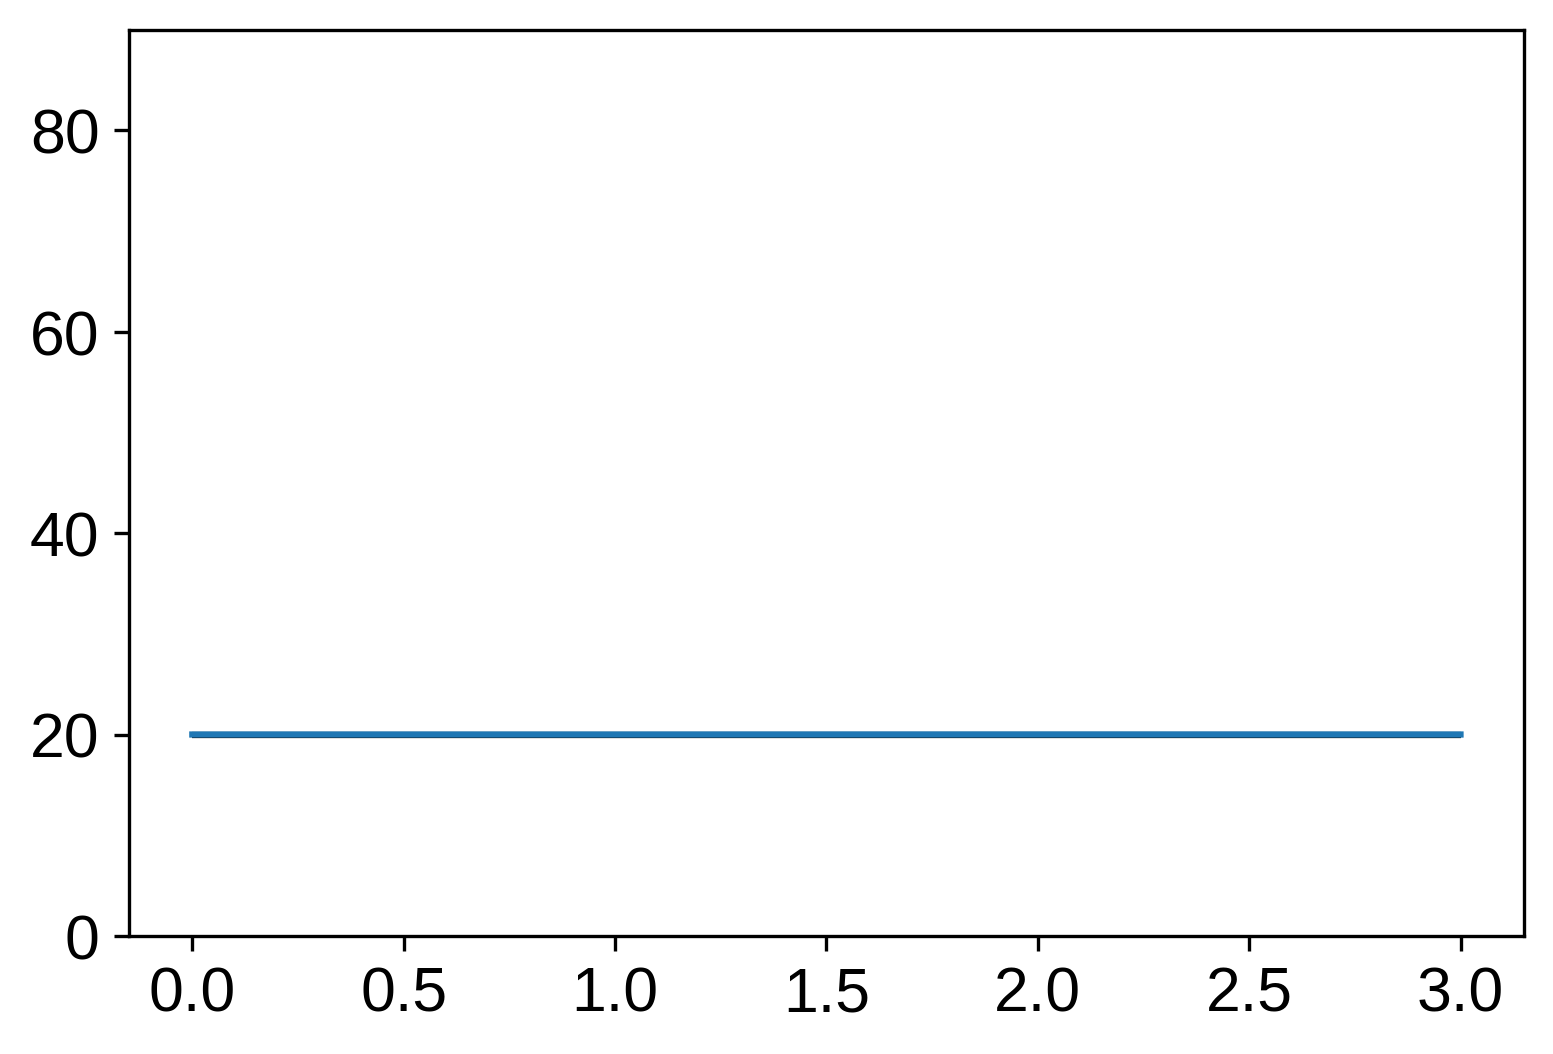

In [22]:
plt.plot(mu[:, 100])
plt.ylim([0, 90])
plt.hlines(deg, 0, 3)

In [23]:
mu = eq_pitch_angle_from_moment(system.history, system.ics[:, 4, 0:2])

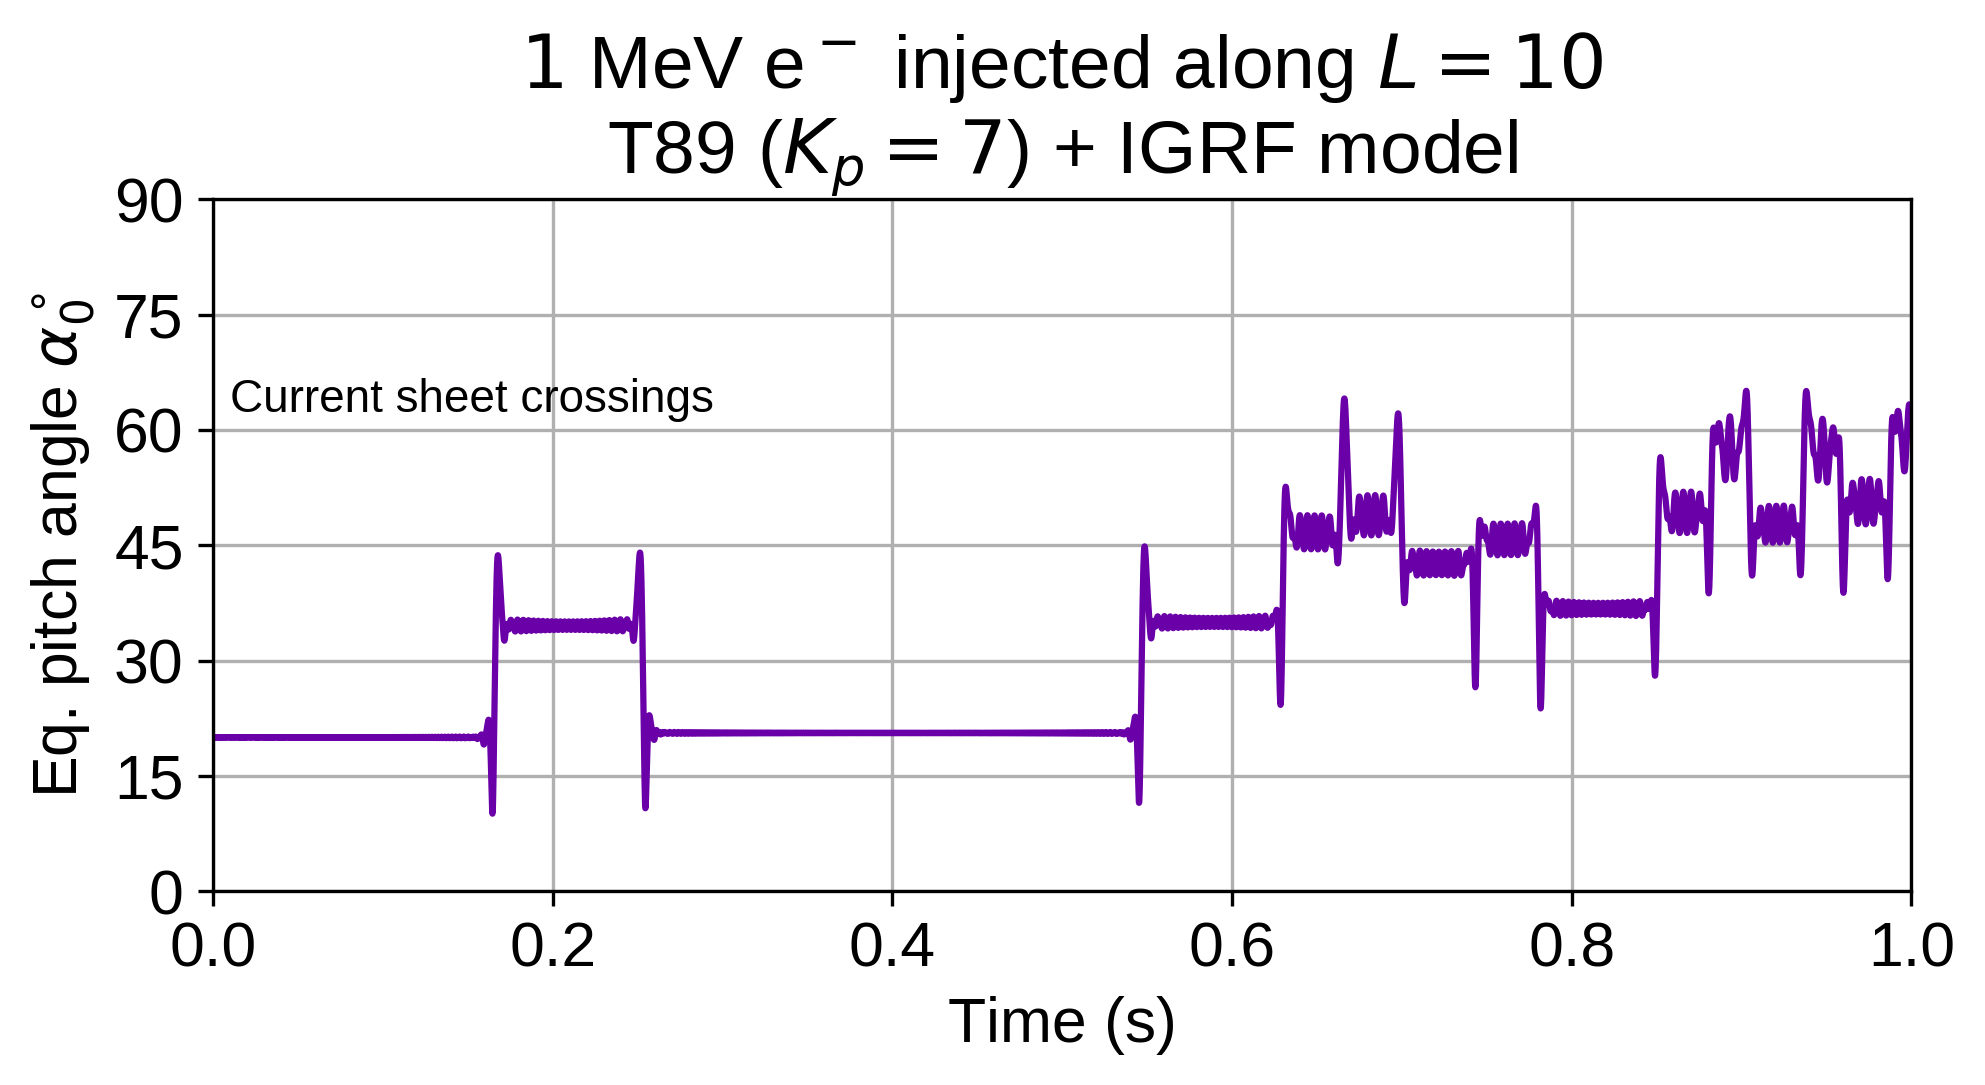

In [24]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

col = plt.cm.plasma(0.2)

fig = plt.figure(figsize=(6, 3))

plt.plot(np.linspace(0, 1, 10000), mu[2, :], color=col)

plt.xlabel(r'Time (s)')
plt.xlim([0, 1])
plt.xticks(np.linspace(0, 1, 6))

plt.ylabel(r'Eq. pitch angle $\alpha_0^\circ$')
plt.ylim([0, 90])
plt.yticks(np.linspace(0, 90, 7))

plt.title('$1$ MeV e$^-$ injected along $L = 10$\nT89 ($K_p=7$) + IGRF model')

plt.text(0.01, 61,  'Current sheet crossings', va='bottom', ha='left', fontsize=11)

plt.grid()
plt.tight_layout(pad=-1.0)
plt.show()

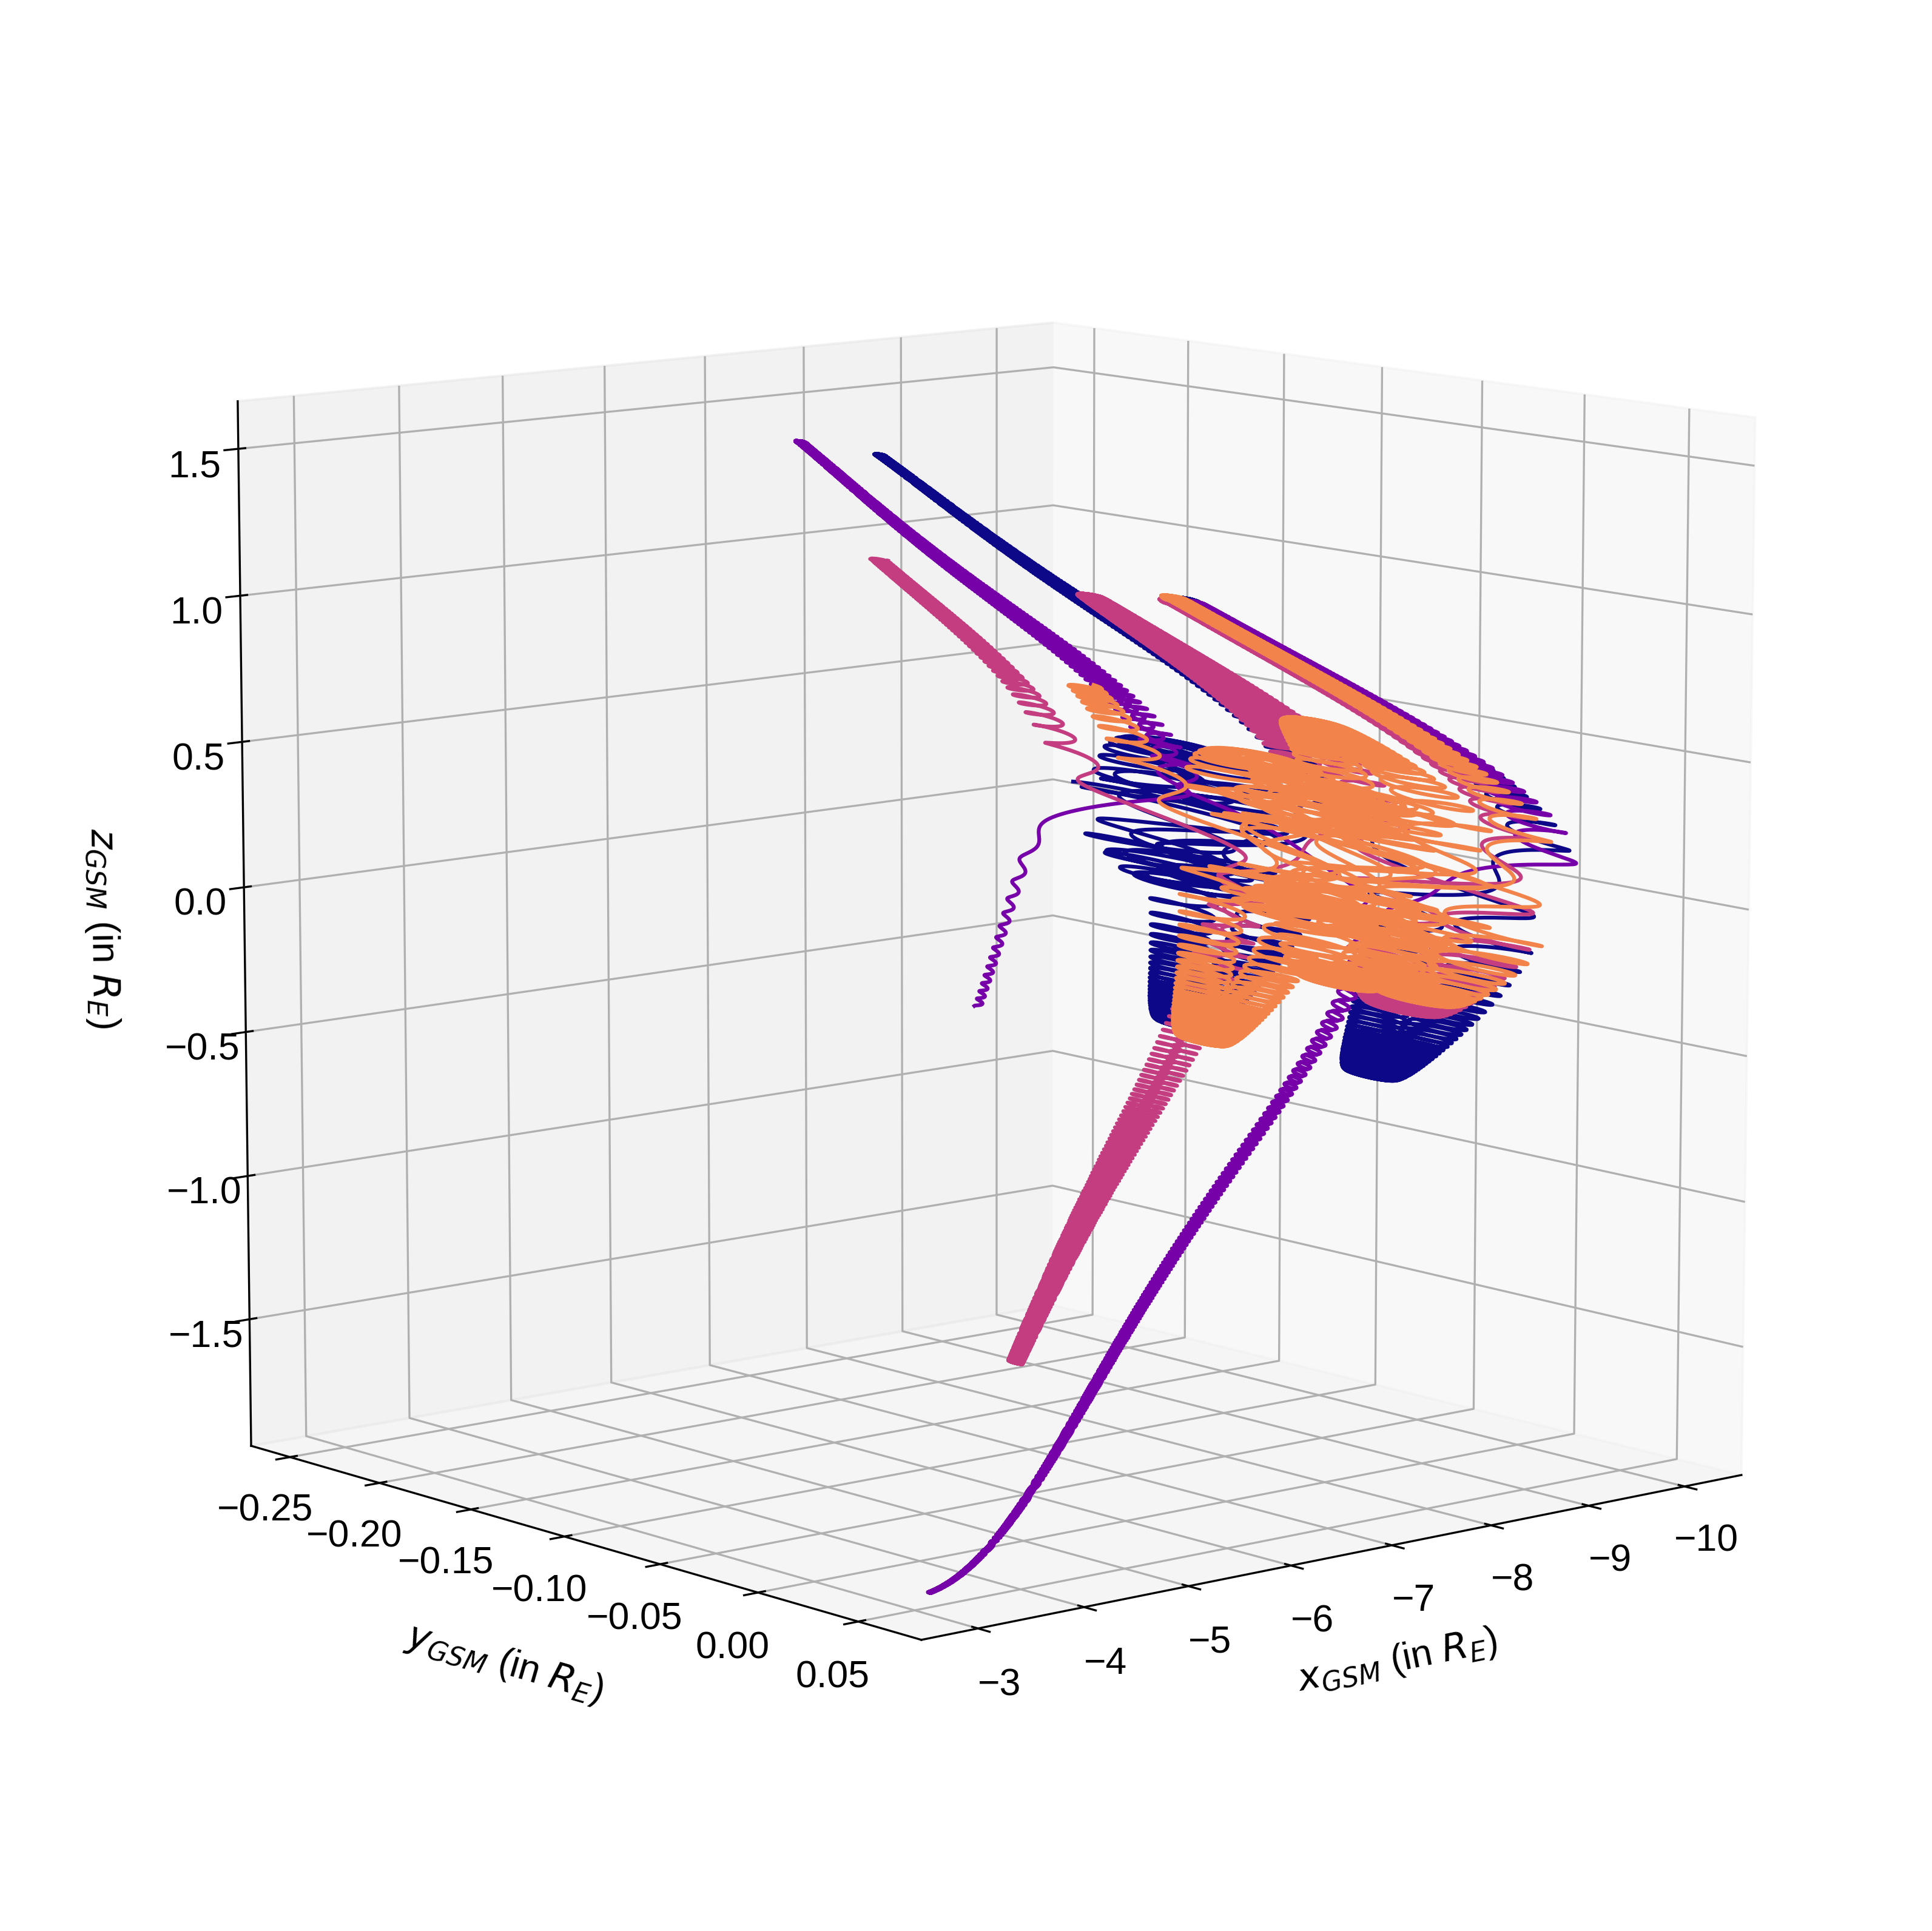

In [78]:
v = system.history[:, :, 1, :]

from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

col = plt.cm.plasma(np.linspace(0, 0.7, 4))

for p, i in enumerate([0, 1, 2, 3]):
    pos = system.history[i, :, 0]
    ax.plot(pos[:, 0] / Re, pos[:, 1] / Re, pos[:, 2] / Re, color=col[i])

ax.set_xlabel('\n$x_{GSM}$ (in $R_E$)', linespacing=1.5)
ax.set_ylabel('\n$y_{GSM}$ (in $R_E$)', linespacing=3)
ax.set_zlabel('\n$z_{GSM}$ (in $R_E$)', linespacing=3)

ax.view_init(10, 50)

plt.grid()
plt.tight_layout(pad=-1)
plt.show()

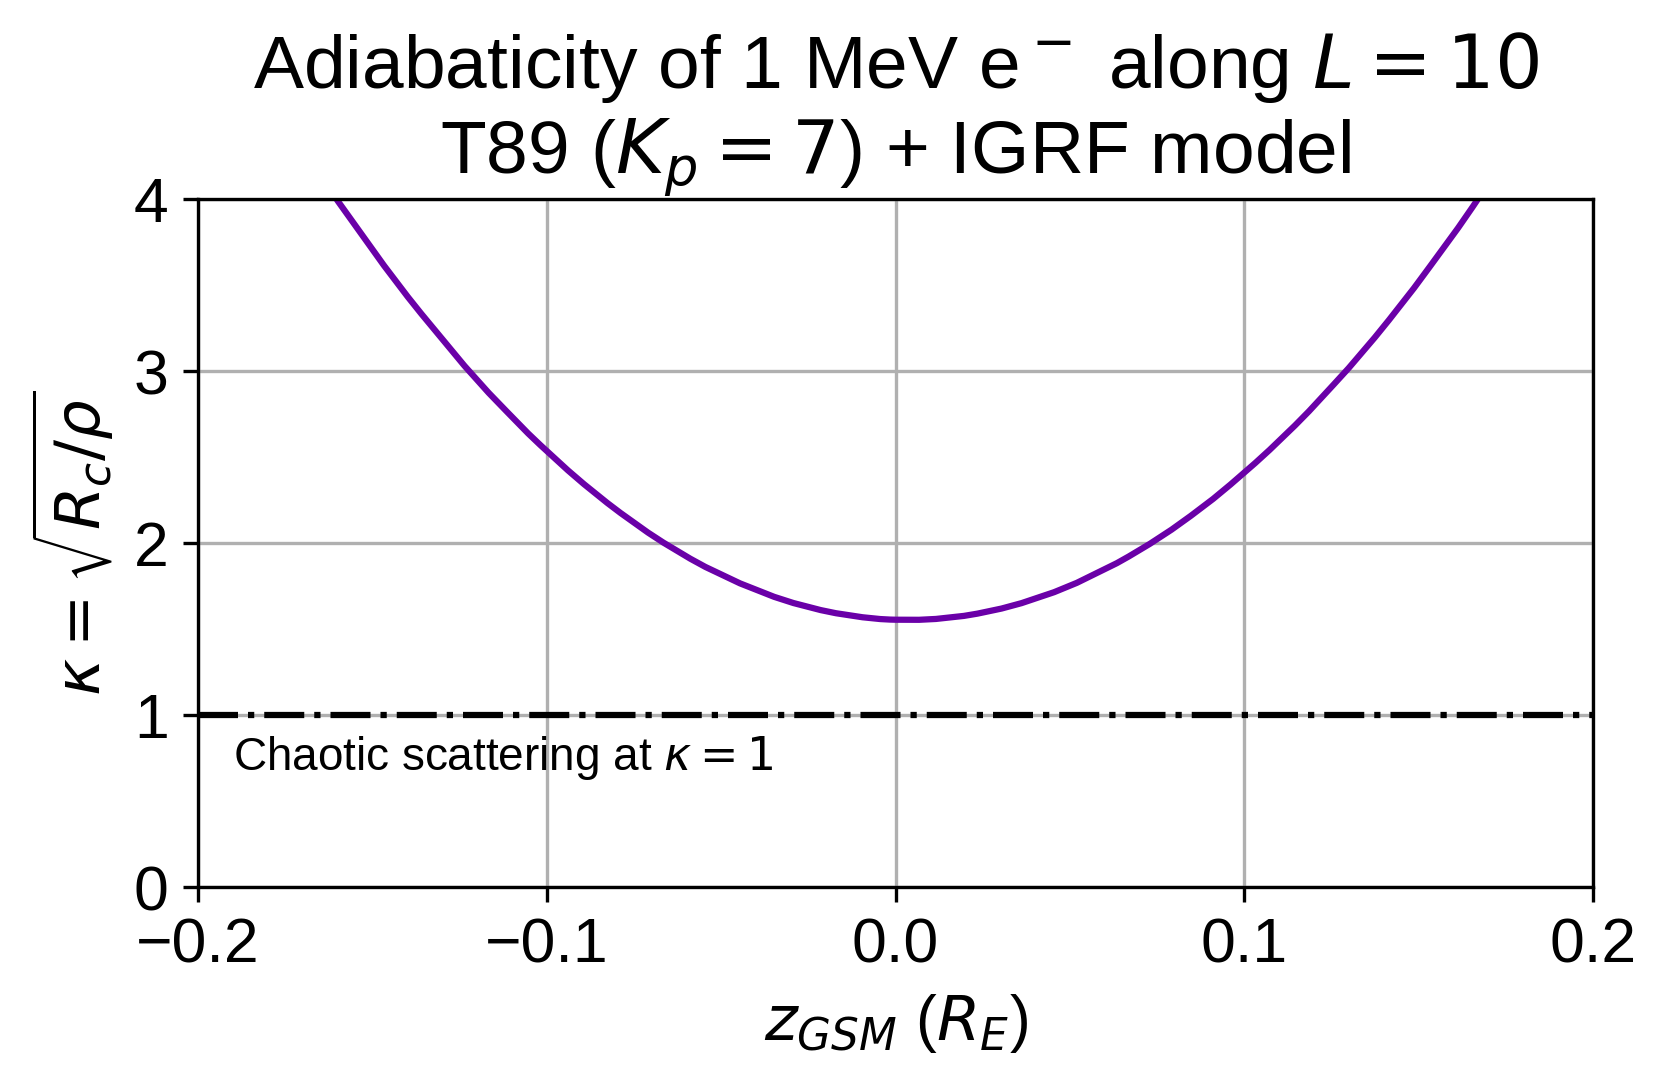

In [3]:
import scipy.constants as sp

plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

fig = plt.figure(figsize=(5, 3))

col = plt.cm.plasma(np.linspace(0.2, 0.7, 3))

for j, K in enumerate([1e6]):
    rr = field_line(b_field, np.array([-10 * Re, 0, 0]), 1e-4)
    kappa = np.zeros(len(rr))

    def gamma_from_E(K, m):
        return 1 + K / (m * sp.c**2)

    def v_rel(g):
        return (sp.c / g) * sqrt(g**2 - 1)

    for i, r in enumerate(rr):
        b = b_field(r)

        v = v_rel(gamma_from_E(eV_to_J(K), sp.m_e))
        v_vec = np.array([v, 0, 0])
        rho_0 = gamma(v_vec) * sp.m_e * np.linalg.norm(v) / (abs(-sp.e) * np.linalg.norm(b))

        R_c = flc(b_field, r)
        kappa[i] = np.sqrt(R_c / rho_0)

    plt.plot(rr[:, 2] / Re, kappa, color=col[j], label=f'{K / 1e6} MeV')


plt.xlabel(r'$z_{GSM}$ ($R_E$)')
plt.ylabel(r'$\kappa = \sqrt{R_c/\rho}$')

plt.xlim([-0.2, 0.2])
plt.ylim([0, 4])

plt.title('Adiabaticity of 1 MeV e$^-$ along $L=10$\nT89 ($K_p=7$) + IGRF model')

plt.hlines([1], -0.2, 0.2, linestyle='-.')
plt.text(-0.19, 0.75, "Chaotic scattering at $\kappa=1$", verticalalignment='center', fontsize=11)

plt.grid()
plt.tight_layout(pad=-1)
plt.show()

In [37]:
ind_list

array([15000., 15000., 15000., ..., 15000., 15000., 15000.])

In [7]:
z = system.history[:, :, 0, 2]
bm = b_mag

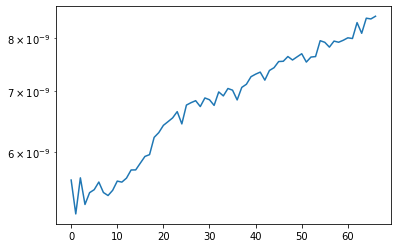

In [36]:
for i in range(len(z[:, 0])):
    if i == 0:
        asign = np.sign(z[i] / Re)
        signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)[1:]
        plt.semilogy(bm[i, np.argwhere(signchange != 0)])

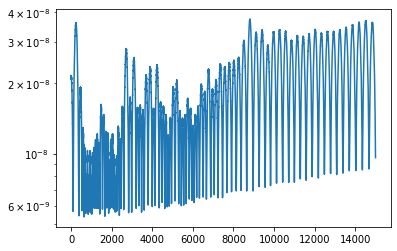

In [37]:
plt.semilogy(bm[i])

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

col = plt.cm.plasma(np.linspace(0.1, 0.6, 2))

fig = plt.figure(figsize=(6, 3))

plt.semilogy(np.linspace(0, b, bins), binned_diffs, color=col[0])

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))

plt.ylim([1e-4, 1])
plt.yticks(color=col[0])
plt.ylabel(r'$D_{\alpha_0\alpha_0}(\alpha_0)$', color=col[0])

plt.grid(True)
plt.gca().xaxis.grid(True)

ax = plt.gca().twinx()
ax.plot(np.linspace(0, b, bins), binned_tcoef, color=col[1])

plt.ylim([-20, 20])
plt.yticks(np.linspace(-20, 20, 5), color=col[1])
plt.ylabel(r'$\langle\Delta\alpha_0\rangle$', color=col[1])

plt.title(r'Diffusion and Transport of $\alpha_0$')

plt.grid()
plt.tight_layout(pad=-1.0)
plt.show()

In [2]:
system.load("presentation2")

Loaded files containing 2.68 gigabytes of information.


In [4]:
@njit
def lost_ind(history):
    num_particles = len(history[:, 0, 0, 0])
    steps         = len(history[0, :, 0, 0])
    
    zero_array = np.zeros((4, 3))
    index_list = np.zeros(num_particles) + steps

    for i in range(num_particles):
        for j in range(steps):
            if (history[i, -(j + 1), :, :] == zero_array).all():
                index_list[i] -= 1
            else:
                break

    return index_list

ind_list = lost_ind(system.history)
lost     = np.where(ind_list < 15000)[0]

In [30]:
r = position(system.history)
r_mag = position_mag(system.history)

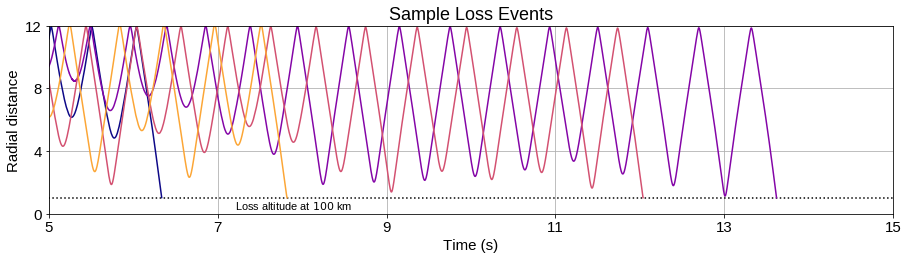

In [44]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

fig = plt.figure(figsize=(12, 3))

col = plt.cm.plasma(np.linspace(0.0, 0.8, 4))

for i, a in enumerate([0, 2, 4, 3]):
    plt.plot(np.arange(0, 1e-3 * ind_list[lost[a]], 1e-3), r_mag[lost[a], 0:int(ind_list[lost[a]])] / Re, color=col[i])
    
plt.xlim([5, 15])
plt.xticks(np.linspace(5, 15, 6))
plt.xlabel('Time (s)')

plt.ylim([1, 12])
plt.yticks(np.linspace(0, 12, 4))
plt.ylabel('Radial distance')

plt.hlines(1.01569612, 0, 15, linestyle=':')
plt.text(7.2, 0.5, r'Loss altitude at $100$ km', verticalalignment='center', fontsize=11)

plt.title('Sample Loss Events')

plt.grid()
plt.tight_layout(pad=-1.0)
plt.show()

In [23]:
@njit
def per_particle_mu_diffusion(history, intrinsic, delta_t, dt):
    num_particles    = len(history[:, 0, 0, 0])
    delta_t_ind      = int(delta_t / dt)
    steps            = int(len(history[0, :, 0, 0]) / delta_t_ind)
    indices          = np.arange(0, steps) * dt
    
    mom = magnetic_moment(history, intrinsic)
    bm  = b_mag(history)
    v   = history[:, :, 1, :]

    mus   = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))
    t_coef = np.zeros((num_particles, steps - 1))

    for i in range(num_particles):
        b_min = np.amin(bm[i, 0:ind_list[i]])
        
        for j in range(steps - 1): 
            if (j + 1) * delta_t_ind > ind_list[i]:
                break
                
            mu_begin = mom[i, j * delta_t_ind] * b_min / (intrinsic[i, 0] * dot(v[i, j * delta_t_ind], v[i, j * delta_t_ind]))
            mu_end = mom[i, (j + 1) * delta_t_ind] * b_min / (intrinsic[i, 0] * dot(v[i, (j + 1) * delta_t_ind], v[i, (j + 1) * delta_t_ind]))
            
            mus[i, j]   = np.degrees(np.arcsin(np.sqrt(2 * mu_begin)))
            if dot(v[i, j * delta_t_ind], history[i, j * delta_t_ind, 2]) < 0:
                mus[i, j] = 180.0 - mus[i, j]
                
            temp_end = np.degrees(np.arcsin(np.sqrt(2 * mu_end)))
            if dot(v[i, (j + 1) * delta_t_ind], history[i, (j + 1) * delta_t_ind, 2]) < 0:
                temp_end = 180.0 - temp_end
                
            D_uus[i, j] = (mu_end - mu_begin)**2 / (2 * delta_t)
            
            t_coef[i, j] = temp_end - mus[i, j]
            
    return mus, D_uus, t_coef

def D_mumu_evolution(history, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    delta_t_4_mus = T / (h_bins + 1)
    mus, D_uus, t_coef = per_particle_mu_diffusion(system.history, system.ics[:, 4, 0:2], delta_t_4_mus, 1e-3)
    
    print(np.shape(mus))

    D_uu_map = np.zeros((v_bins, h_bins))
    t_coef_map = np.zeros((v_bins, h_bins))

    for i in range(h_bins):
        D_uu_averaged = [[] for k in range(v_bins)]
        t_coef_averaged = [[] for k in range(v_bins)]
        
        bin_size = 180.0 / v_bins
        
        for j in range(len(mus[:, i])):
            bin_ind = int(round((mus[j, i] - bin_size) / bin_size))
            if bin_ind == v_bins:
                bin_ind -= 1
            D_uu_averaged[bin_ind].append(D_uus[j, i])
            t_coef_averaged[bin_ind].append(t_coef[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
        
        for k, d in enumerate(t_coef_averaged):
            if len(d) == 0:
                t_coef_averaged[k].append(0)

        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))
        t_coef_map[:, i] = np.flip(np.array([np.mean(k) for k in t_coef_averaged]))
        
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['font.family'] = 'Liberation Sans'

    fig = plt.figure(figsize=(7, 5))
    
    plt.subplot(1, 1, 1)
    im = plt.gca().imshow(D_uu_map, cmap='plasma', norm=color.LogNorm(vmin=1e-4, vmax=1e-1))

    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(180, 0, 5)])
    
    plt.xlabel('Time (s)')
    plt.ylabel(r'Eq. pitch angle $\alpha_0^\circ$')
    plt.title(r'Eq. pitch angle diffusion')
    
    cbar = plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(r'$D_{\alpha_0\alpha_0}(\alpha_0)$  s$^{-1}$', rotation=-90, va="bottom")
    
    plt.tight_layout(pad=2.0)
    plt.show()
    
    return D_uu_map, t_coef_map

(2000, 120)


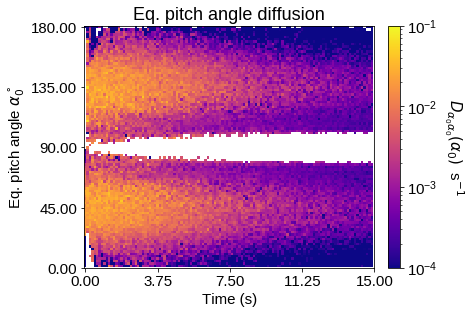

In [24]:
duumap, tcmap = D_mumu_evolution(system.history, 120, 100, 15, 1e-3)

In [21]:
def eq_pa_evolution(history, ics, h_bins, v_bins, T):
    delta_t_4_mus = T / (h_bins + 1)
    mus, D_uus, t_coef = per_particle_mu_diffusion(system.history, system.ics[:, 4, 0:2], delta_t_4_mus, 1e-3)
    
    #pas = eq_pitch_angle_from_moment(history, ics[:, 4, 0:2])
    pas_map = np.zeros((v_bins, h_bins))

    h_max = len(mus[0, :])

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        pas_at_t = mus[:, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 180, num=v_bins + 1))[0])
        
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['font.family'] = 'Liberation Sans'

    fig = plt.figure(figsize=(7, 5))
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma', norm=color.LogNorm(vmin=1e0, vmax=1e2))
    
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(180, 0, 5)])
    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    
    plt.ylabel(r'Eq. pitch angle $\alpha_0^\circ$')
    plt.xlabel('Time (s)')
    plt.title('Eq. pitch angle distribution')
    
    cbar = plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Particle count (AU)', rotation=-90, va="bottom")
    
    plt.tight_layout(pad=2.0)
    plt.show()

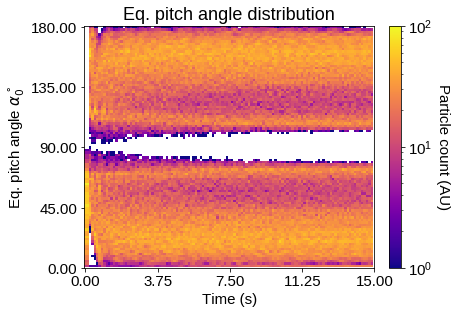

In [22]:
eq_pa_evolution(system.history, system.ics, 120, 100, 15)

In [ ]:
@njit
def per_particle_diffusion(history, delta_t, dt):
    num_particles    = len(history[:, 0, 0, 0])
    delta_t_ind      = int(delta_t / dt)
    steps            = int(len(history[0, :, 0, 0]) / delta_t_ind)
    v                = velocity(history)
    indices          = np.arange(0, steps) * dt

    mus    = np.zeros((num_particles, steps - 1)) - 1
    D_uus  = np.zeros((num_particles, steps - 1)) - 1
    t_coef = np.zeros((num_particles, steps - 1)) - 1

    for i in range(num_particles):
        for j in range(steps - 1):
            if (j + 1) * delta_t_ind > ind_list[i]:
                break
                
            v_par_mag_beg   = dot(v[i, j * delta_t_ind], history[i, j * delta_t_ind, 2, :]) / np.linalg.norm(history[i, j * delta_t_ind, 2, :])
            v_par_mag_end   = dot(v[i, (j + 1) * delta_t_ind], history[i, (j + 1) * delta_t_ind, 2, :]) / np.linalg.norm(history[i, (j + 1) * delta_t_ind, 2, :])
            
            mu_begin     = v_par_mag_beg / np.linalg.norm(v[i, j * delta_t_ind])
            mu_end       = v_par_mag_end / np.linalg.norm(v[i, (j + 1) * delta_t_ind])
            D_uus[i, j]  = (mu_end - mu_begin)**2 / (2 * delta_t)
            mus[i, j]    = mu_begin
            t_coef[i, j] = mu_begin - mu_end
            
    return mus, D_uus, t_coef

def D_uu_evolution(history, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    delta_t_4_mus = T / (h_bins + 1)
    mus, D_uus, t_coef = per_particle_diffusion(history, delta_t_4_mus, 1e-3)

    D_uu_map = np.zeros((v_bins, h_bins))
    t_coef_map = np.zeros((v_bins, h_bins))

    for i in range(h_bins):
        D_uu_averaged = [[] for k in range(v_bins)]
        t_coef_averaged = [[] for k in range(v_bins)]

        bin_size = 2.0 / v_bins

        for j in range(len(mus[:, i])):
            bin_ind = floor((mus[j, i] + 1) // bin_size)
            
            if mus[j, i] != -1 and D_uus[j, i] != -1 and t_coef[j, i] != -1:
                D_uu_averaged[bin_ind].append(D_uus[j, i])
                t_coef_averaged[bin_ind].append(t_coef[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
                
        for k, d in enumerate(t_coef_averaged):
            if len(d) == 0:
                t_coef_averaged[k].append(0)
                
        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))
        t_coef_map[:, i] = np.flip(np.array([np.mean(k) for k in t_coef_averaged]))
    
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['font.family'] = 'Liberation Sans'

    fig = plt.figure(figsize=(6.5, 6.5))
    
    plt.subplot(1, 1, 1)
    im = plt.gca().imshow(D_uu_map, cmap='plasma', norm=color.LogNorm(vmin=1e-2, vmax=1e1))

    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(1, -1, 5)])
    
    plt.xlabel('Time (s)')
    plt.ylabel(r'$\mu = v_{\parallel}/v$')
    plt.title(r'Inst. pitch angle diffusion')
    
    cbar = plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(r'$D_{\mu\mu}(\mu)$  s$^{-1}$', rotation=-90, va="bottom")
    
    plt.tight_layout(pad=2.0)
    plt.show()

In [ ]:
D_uu_evolution(system.history, 200, 200, 15, 1e-3)

In [54]:
system.load("5000_12Re_1MeV_20pa")

Loaded files containing 916.10 megabytes of information.


In [41]:
system.load("pres3")

Loaded files containing 2.68 gigabytes of information.


In [96]:
system.populate(4000,
                delta(rr[338]),
                delta(1e6),
                delta(np.radians(90)),
                uniform(0, 2 * np.pi)
               )

system.solve(2, 1e-4, 1e-3)

100%|██████████| 4000/4000 [04:28<00:00, 14.91it/s]


In [109]:
eqpas = eq_pitch_angle_from_moment(system.history, system.ics[:, 4, 0:2])

(array([ 619., 1031.,  884.,  694.,  396.,  189.,   88.,   63.,   28.,
           8.]),
 array([ 0.75057736,  8.74702686, 16.74347636, 24.73992585, 32.73637535,
        40.73282485, 48.72927434, 56.72572384, 64.72217334, 72.71862283,
        80.71507233]),
 <a list of 10 Patch objects>)

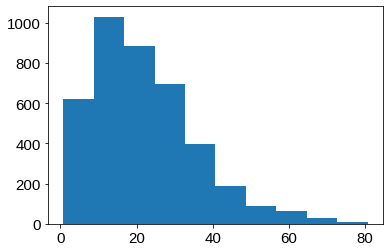

In [120]:
plt.hist(eqpas[:, 500])

In [100]:
eq_pa_evolution(system.history, system.ics, 200, 200, 2)

ValueError: Failed in nopython mode pipeline (step: inline inlinable functions)
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [18]:
system.load("EQ_5000_10_1e6_20_0-360")

Loaded files containing 916.10 megabytes of information.


In [19]:
particles = len(system.history[:, 0, 0, 0])
steps     = len(system.history[0, :, 0, 0])
eps       = 0.5 * Re

#for s in range(steps):
#    inds = np.where(np.abs(system.history[:, s, 0, 2]) <= eps)[0]
#    print(pas[inds])
    
def pa_eq_plane_evolution(history, h_bins, v_bins, T, folded=False):
    pas = pitch_angle(history)
    pas_map = np.zeros((v_bins, h_bins))
    
    if folded:
        for i in range(len(pas[:, 0])):
            for j in range(len(pas[0, :])):
                p = pas[i, j]

                if p <= 90:
                    continue
                else:
                    pas[i, j] = 180 - p
    
    eps = 0.05 * Re
    h_max = len(pas[0, :])
    
    degs = 180
    if folded:
        degs = 90

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        width = floor((h_max - 1) / h_bins)
        pas_at_t = []
        
        for j in range(width):
            p_inds = np.where(np.abs(history[:, t_ind + j, 0, 2]) <= eps)[0]
            apasat = pas[p_inds, t_ind + j]
            for k in apasat:
                pas_at_t.append(k)
            
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, degs, num=v_bins + 1))[0])
        
        if np.isnan(pas_map[:, i]).all():
            pas_map[:, i] = np.zeros(v_bins)
        
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['font.family'] = 'Liberation Sans'
        
    fig = plt.figure(figsize=(6, 3.5)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma', norm=color.LogNorm(vmin=1, vmax=1e3))
    
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(degs, 0, 5)])
    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    
    plt.ylabel('Pitch angle $\\alpha^\circ$')
    plt.xlabel('Time (s)')
    plt.title(f'$1$ MeV e$^-$ injected along $L = 12$\n$\\alpha_{{init}}={deg}$ deg, T89 + IGRF model')
    
    cbar = plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Particle count (AU)\nwithin $z = \pm0.05R_E$', rotation=-90, va="bottom")
    
    plt.show()

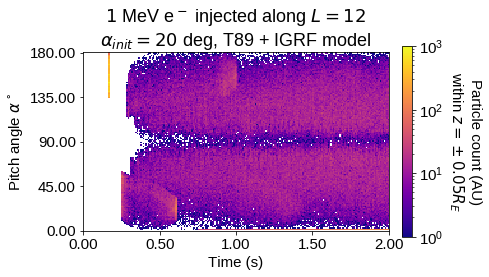

In [20]:
pa_eq_plane_evolution(system.history, 240, 140, 2, False)

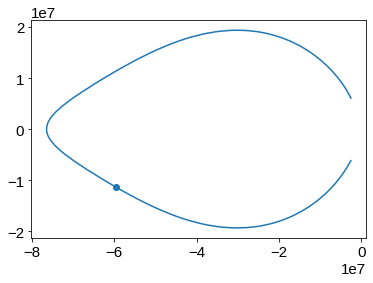

In [7]:
plt.plot(rr[:, 0], rr[:, 2])
plt.scatter(rr[89, 0], rr[89, 2])